<a href="https://www.kaggle.com/code/leokaka/class-activation-maps-cams?scriptVersionId=268113557" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [18]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Debugging CNNs with Class Activation Maps

This implementation is based on the [Grad-CAM](https://arxiv.org/pdf/1610.02391) paper.

## Observations:
1. If a pixel strongly influences the model’s decision, the CNN will show a high activation value at that pixel (1).
   
3. If a particular feature channel is crucial for predicting the target class, its gradient values will be large (2).
   
## Implementations:
1. (1) represents the feature map produced during the forward pass of the image through the network.

2. (2) represents the gradient of the activated input, obtained by backpropagating from the selected logit of the CNN.

3. We can multiply (1) and (2) to get a weighted activation map, also known as a class activation map (CAM).

4. Since the size of (3) is smaller than the original image, we need to resize it so that the activation regions align correctly with the original image.

## All steps in details can be described by the following image:

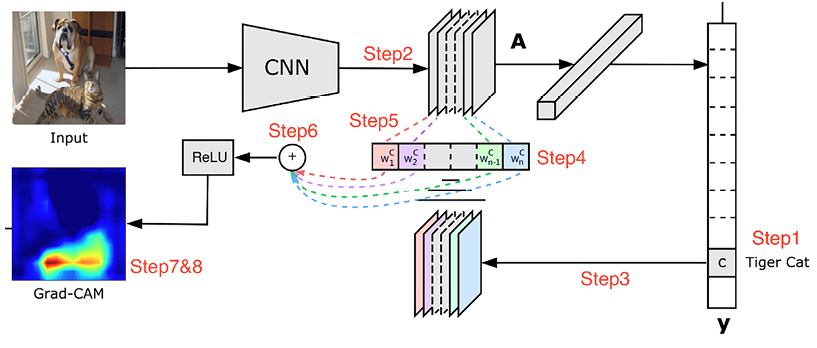

In [19]:
import torch
import numpy as np
import pandas as pd 
import os
print(os.listdir('../input/cell-images-for-detecting-malaria/cell_images'))

['Uninfected', 'Parasitized', 'cell_images']


In [20]:
from torchvision import transforms

train_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(128),
                                     transforms.CenterCrop(128),
                                     transforms.ColorJitter(brightness=(0.95,1.05), 
                                                          contrast=(0.95, 1.05),
                                                          saturation=(0.95,1.05),
                                                          hue=0.05),
                                     transforms.RandomAffine(5, translate=(0.01, 0.1)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5,0.5,0.5],
                                                          std=[0.5,0.5,0.5]),
                                     
])

val_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize(128),
                                     transforms.CenterCrop(128),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5,0.5,0.5],
                                                          std=[0.5,0.5,0.5]),
                                     
])

In [21]:
id2int = {'Parasitized': 0, 'Uninfected': 1}

In [22]:
from torch.utils.data import Dataset, DataLoader
from cv2 import imread as read

class MalariaImages(Dataset):
    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        file_path = self.files[idx]
        cls = os.path.basename(os.path.dirname(file_path))
        img = read(file_path, 1)
        return img, cls
    def choose(self):
        return self[randint(len(self))]
    def collate_fn(self, batch):
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
        classes = [torch.tensor([id2int[cls]]) for cls in classes]
        imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
        return imgs, classes, _imgs

In [23]:
from glob import glob
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
all_files = glob('../input/cell-images-for-detecting-malaria/cell_images/*/*.png')
np.random.seed(10)
np.random.shuffle(all_files)

from sklearn.model_selection import train_test_split
trn_files, val_files = train_test_split(all_files, random_state=1)

trn_ds = MalariaImages(trn_files, transform=train_transform)
val_ds = MalariaImages(val_files, transform=val_transform)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

In [24]:
import torch.nn as nn

def convBlock(n_in, n_out):
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(n_in, n_out, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(n_out),
        nn.MaxPool2d(2)
    )

class MalariaClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int))
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

In [25]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, labels, _ = data
    _preds = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, labels, _ = data
    _preds = model(ims)
    loss, acc = criterion(_preds, labels)
    return loss.item(), acc.item()

In [26]:
import torch.optim as optim
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 2

for ex in range(n_epochs):
    print(f"\nEpoch [{ex+1}/{n_epochs}]")

    # ---------- TRAIN LOOP ----------
    trn_loss_sum, trn_acc_sum = 0.0, 0.0
    N = len(trn_dl)

    for bx, data in enumerate(trn_dl, 1):
        loss, acc = train_batch(model, data, optimizer, criterion)
        trn_loss_sum += loss
        trn_acc_sum += acc

        if bx % 10 == 0 or bx == N:
            print(f"  [Train] Batch {bx}/{N} | Loss: {loss:.4f} | Acc: {acc:.4f}", end='\r')

    trn_loss_avg = trn_loss_sum / N
    trn_acc_avg = trn_acc_sum / N
    print(f"\n  [Train] Avg Loss: {trn_loss_avg:.4f} | Avg Acc: {trn_acc_avg:.4f}")

    # ---------- VALIDATION LOOP ----------
    val_loss_sum, val_acc_sum = 0.0, 0.0
    N = len(val_dl)

    for bx, data in enumerate(val_dl, 1):
        loss, acc = validate_batch(model, data, criterion)
        val_loss_sum += loss
        val_acc_sum += acc

        if bx % 10 == 0 or bx == N:
            print(f"  [Val]   Batch {bx}/{N} | Loss: {loss:.4f} | Acc: {acc:.4f}", end='\r')

    val_loss_avg = val_loss_sum / N
    val_acc_avg = val_acc_sum / N
    print(f"\n  [Val]   Avg Loss: {val_loss_avg:.4f} | Avg Acc: {val_acc_avg:.4f}")


Epoch [1/2]
  [Train] Batch 646/646 | Loss: 0.4091 | Acc: 0.8571
  [Train] Avg Loss: 0.2516 | Avg Acc: 0.9009
  [Val]   Batch 216/216 | Loss: 0.0427 | Acc: 1.0000
  [Val]   Avg Loss: 0.2314 | Avg Acc: 0.9359

Epoch [2/2]
  [Train] Batch 646/646 | Loss: 0.2129 | Acc: 0.9286
  [Train] Avg Loss: 0.1728 | Avg Acc: 0.9450
  [Val]   Batch 216/216 | Loss: 0.0861 | Acc: 1.0000
  [Val]   Avg Loss: 0.1719 | Avg Acc: 0.9488


In [27]:
im2fmap = nn.Sequential(*(list(model.model[:5].children()) + list(model.model[5][:2].children())))

In [28]:
im2fmap

Sequential(
  (0): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

# Weighted Activation Map Extraction

1. We extract the feature map from the last block (block 6) of the model using a forward pass.

2. The convolutional element is model.model[-6][1]; we can verify this by simply running print(model.model[-6]).

3. The logic behind gradient extraction is as follows: suppose the output from the last layer has a shape of (N_out, N_in, kernel_size, kernel_size) = (512, 256, 3, 3).
In that case, we take the average over the dimensions (N_in, kernel_size, kernel_size) to obtain a gradient shape that matches the feature map dimensions -> average (0,2,3).


In pytorch, the shape of grad is different. For example, (6): Conv2d(512, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) will result in shape of (64, 512, 3, 3). Therefore, the above logic in step 3 should be adjusted as average through (1,2,3).

In [29]:
def im2gradCAM(x):
    model.eval()
    logits = model(x)
    print(logits.shape)
    heatmaps = []
    activations = im2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]
    print(pred)
    # get the model's prediction
    model.zero_grad()
    # compute gradients with respect to model's most confident logit
    logits[0,pred].backward(retain_graph=True)
    # get the gradients at the required featuremap location
    # and take the avg gradient for every featuremap
    print(model.model[-6][1].weight.grad.data.shape)
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1,2,3))
    # multiply each activation map with corresponding gradient average
    for i in range(activations.shape[1]):
        activations[:,i,:,:] *= pooled_grads[i]
    # take the mean of all weighted activation maps
    # (that has been weighted by avg. grad at each fmap)
    heatmap = torch.mean(activations, dim=1)[0].cpu().detach()
    return heatmap, 'Uninfected' if pred.item() else 'Parasitized'

In [30]:
SZ = 128
def upsampleHeatmap(map, img):
    m,M = map.min(), map.max()
    map = 255 * ((map-m) / (M-m))
    map = np.uint8(map)
    map = cv2.resize(map, (SZ,SZ))
    map = cv2.applyColorMap(255-map, cv2.COLORMAP_JET)
    map = np.uint8(map)
    map = np.uint8(map*0.7 + img*0.3)
    return map

torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([0], device='cuda:0')
torch.Size([64, 512, 3, 3])


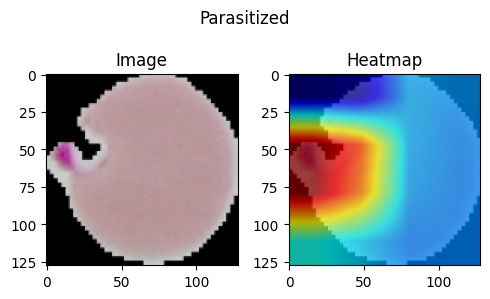

torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([0], device='cuda:0')
torch.Size([64, 512, 3, 3])


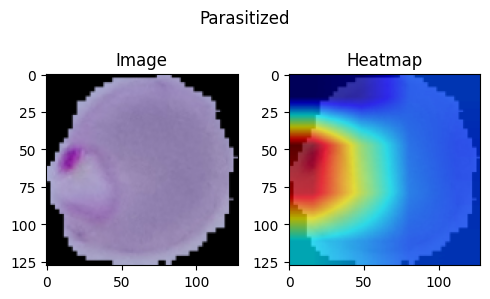

torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([0], device='cuda:0')
torch.Size([64, 512, 3, 3])


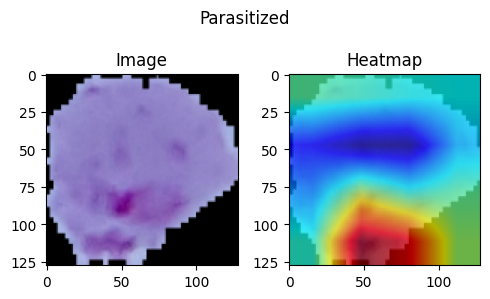

torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([0], device='cuda:0')
torch.Size([64, 512, 3, 3])


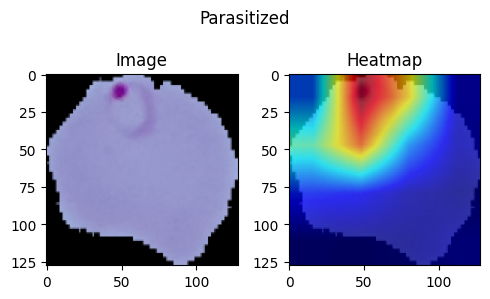

torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([0], device='cuda:0')
torch.Size([64, 512, 3, 3])


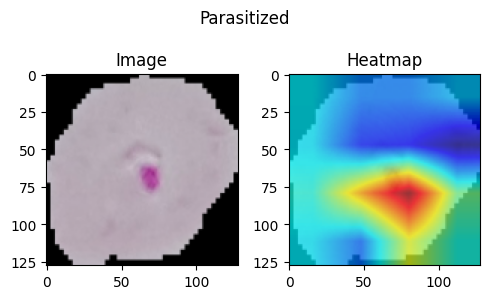

torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([0], device='cuda:0')
torch.Size([64, 512, 3, 3])


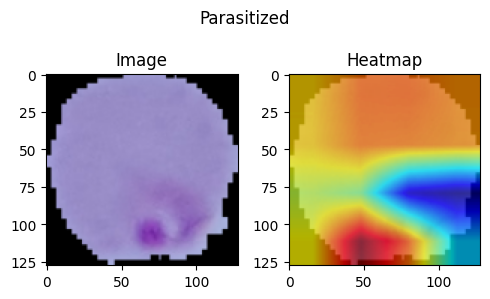

torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([0], device='cuda:0')
torch.Size([64, 512, 3, 3])


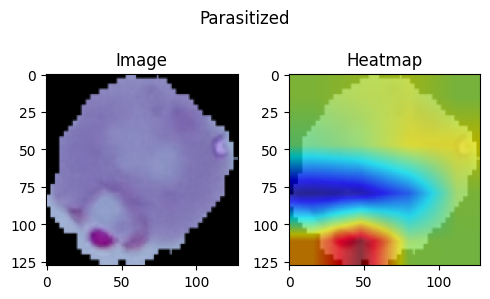

torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([0], device='cuda:0')
torch.Size([64, 512, 3, 3])


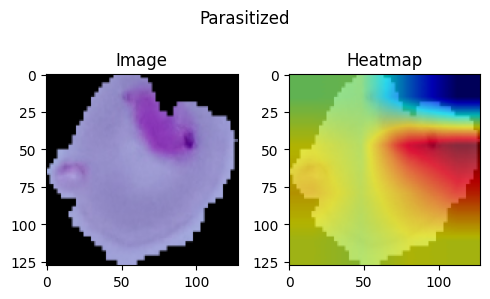

torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])
torch.Size([1, 2])
torch.Size([1, 64, 4, 4])
tensor([1], device='cuda:0')
torch.Size([64, 512, 3, 3])


In [31]:
import cv2
import matplotlib.pyplot as plt

N = 20
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x,y,z = next(iter(_val_dl))

for i in range(N):
    image = cv2.resize(z[i], (SZ,SZ))
    heatmap, pred = im2gradCAM(x[i:i+1])
    if(pred=='Uninfected'):
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[1].imshow(heatmap)
    axes[1].set_title("Heatmap")
    fig.suptitle(pred)
    plt.tight_layout()
    plt.show()
